In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [3]:
df = pd.read_csv('DataBase.csv')
df

,time,input,output
0,0.100,0,826
1,0.102,0,917
2,0.113,0,937
3,0.153,1,963
4,0.194,1,1023
...,...,...,...
701,29.870,212,248
702,29.913,212,476
703,29.956,212,362
704,30.000,213,286


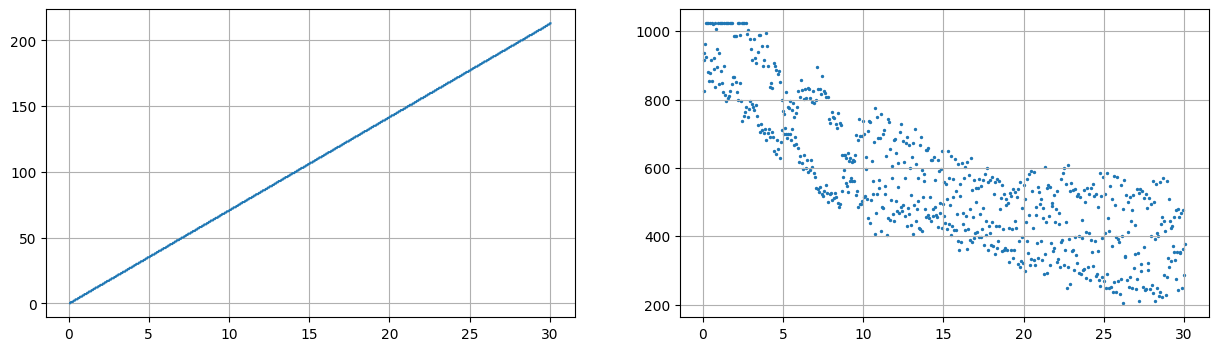

In [4]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input)
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

## FREQUÊNCIA DE AMOSTRAGEM
- Os dados precisam ter uma frequência de amostragem constante

In [5]:
def normalizeData(time, response, T=0.01):
    tData = np.arange(time[0], time[-1], T)
    xData = []
    yData = []

    for i in range(len(tData) - 1):
        currentTime = tData[i]
        nextTime    = tData[i + 1]
        target = response[(time >= currentTime) & (time < nextTime)]

        xData.append(currentTime)
        yData.append(np.mean(target))

    return np.array(xData), np.array(yData)

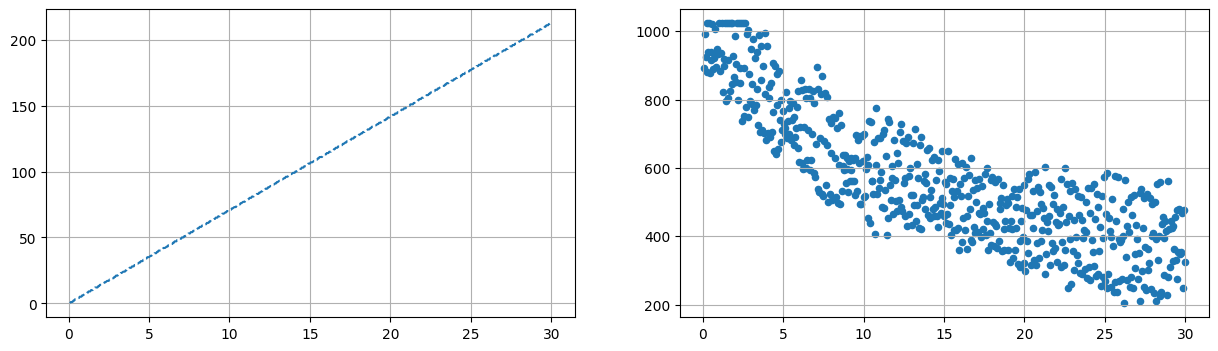

In [6]:
tData, uData = normalizeData(df.time.values, df.input.values, T=0.05)
tData, yData = normalizeData(df.time.values, df.output.values, T=0.05)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(tData, uData, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(tData, yData, s=20)
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [7]:
def g(u, a, b, c, d, e):
    s = ctl.TransferFunction.s
    G = (a*s**2 + b*s + c)/(s**2 + d*s + e)
    return ctl.forced_response(G, T=tData, U=uData)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [8]:
coefs = getFunction(uData, yData)  
coefs

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


[221.96462324706607,
 59.07446160736178,
 -1.1006666839242674,
 1.5707738149078152,
 0.614309170752948]

In [9]:
s = ctl.TransferFunction.s
a, b, c, d, e = coefs

G = (a*s**2 + b*s + c)/(s**2 + d*s + e)
G

TransferFunction(array([221.96462325,  59.07446161,  -1.10066668]), array([1.        , 1.57077381, 0.61430917]))

### CONFERINDO COM A DATABASE

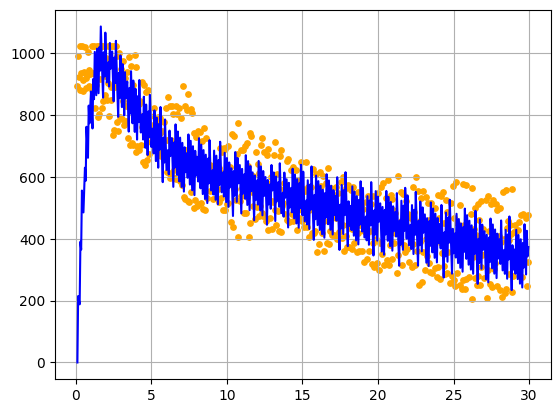

In [10]:
time, response = ctl.forced_response(G, T=tData, U=uData)
plt.plot(time, response, color='blue')
plt.scatter(tData, yData, color='orange', s=15)
plt.grid()

polos:  (-0.836+0j) (-0.735+0j)
zeros:  (-0.284+0j) (0.017+0j)


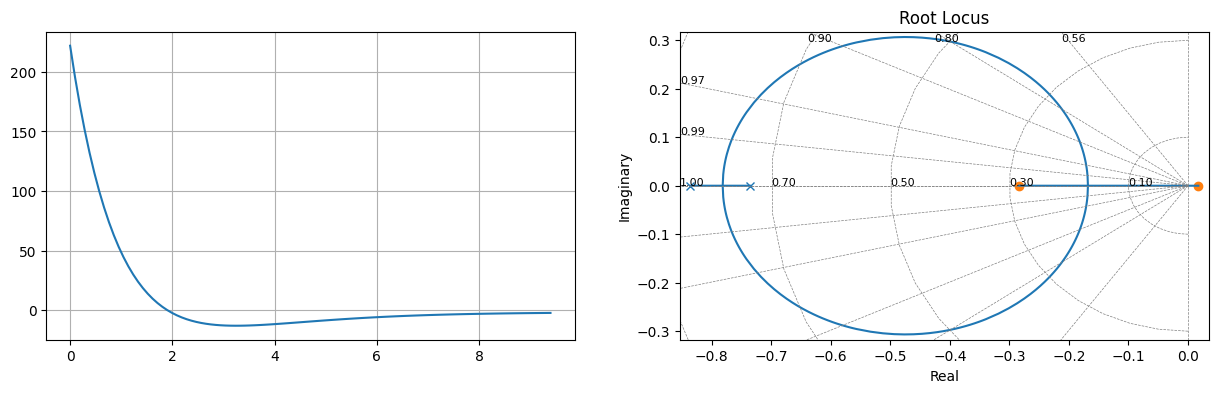

In [11]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

In [12]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

(221.964623247066*s**2 + 59.0744616073618*s - 1.10066668392427)/(1.0*s**2 + 1.57077381490782*s + 0.614309170752948)
